<h1 align="center">Scientific Programming in Python</h1>
<h2 align="center">Topic 8: Basics of Data Parallelism  </h2> 


_Notebook created by Felipe Mancilla S - `felipe.mancilla@alumnos.usm.cl` - DI UTFSM - June 2017._

In [1]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import threading
import multiprocessing
from ipyparallel import Client

def image_plot(img):
    """
    img is an (nx,ny,3) numpy.array
    """
    plt.figure(figsize=(12,12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

En esta actividad realizaremos convolución de imágenes (tarea altamente paralelizable), sobre imágenes de gran tamaño y de forma paralela, utilizando bibliotecas de paralelización en Python.

En primer lugar cargamos y visualizamos la imágen a trabajar:

In [2]:
img = plt.imread('heic1608b.jpg', format='jpeg')[0:8660,:,:]
print(img.shape)

(8660, 10260, 3)


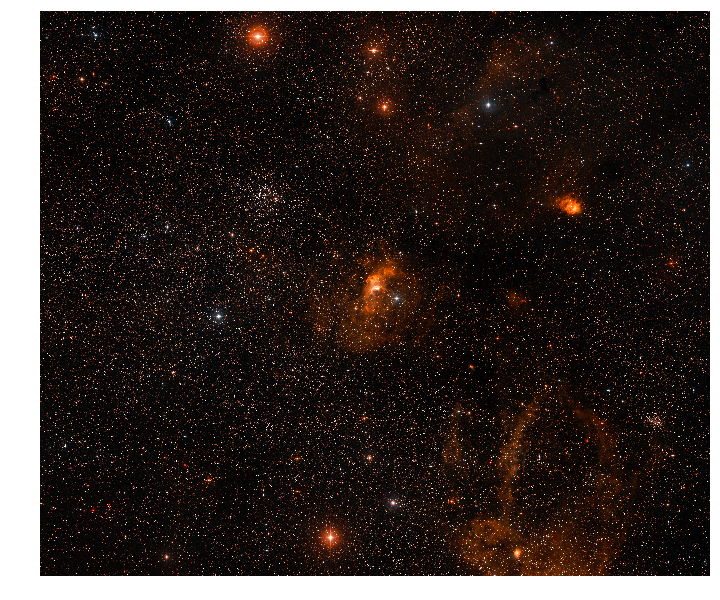

In [3]:
image_plot(img)

Lo que se desea es aplicar un filtro de _blurring_ (Gaussiano) sobre tal imágen. En este caso ocuparemos en filtro/kernel Gaussiano de `5x5` generado por la siguiente función:

In [4]:
def gaussian_kernel(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [5]:
K = gaussian_kernel((5,5))
print(K)

[[  6.96247819e-08   2.80886418e-05   2.07548550e-04   2.80886418e-05
    6.96247819e-08]
 [  2.80886418e-05   1.13317669e-02   8.37310610e-02   1.13317669e-02
    2.80886418e-05]
 [  2.07548550e-04   8.37310610e-02   6.18693507e-01   8.37310610e-02
    2.07548550e-04]
 [  2.80886418e-05   1.13317669e-02   8.37310610e-02   1.13317669e-02
    2.80886418e-05]
 [  6.96247819e-08   2.80886418e-05   2.07548550e-04   2.80886418e-05
    6.96247819e-08]]


Para ello se le solicita lo siguiente:

1. Usando `IPython.Parallel` desarrolle una solución para aplicar el filtro de convolución `K` sobre la imágen dada. Usted es libre de elegir el modo (_synchronous_ o _asynchronous_) y el modo de despacho de tareas. __Notar:__ Que la imágen tiene 3 canales (RGB) y debe aplicar el filtro independientemente en cada uno.
2. Ejecute su solución sobre la imágen y muestre el resultado.
3. Ejecute su solución anterior sobre un _pool_ de `1`, `2`, `4` y `8` _engines_ realizando un análisis de tiempo con `%timeit`. Extraiga conclusiones de los resultados obtenidos (considere las características del CPU de su computador). 

#1. Usando `IPython.Parallel` desarrolle una solución para aplicar el filtro de convolución `K` sobre la imágen dada. Usted es libre de elegir el modo (_synchronous_ o _asynchronous_) y el modo de despacho de tareas. __Notar:__ Que la imágen tiene 3 canales (RGB) y debe aplicar el filtro independientemente en cada uno.

Desarrollamos una función para la convolución de la imagen.

In [6]:
@numba.jit('float32[:,:] (float32[:,:])', nopython=True)
def imageConvolution(image):
    row = image.shape[0]
    column = image.shape[1]
    temp = np.copy(image)    
    columnToFilter = column - 4
    rowToFilter = row - 4
    for i in range(0,rowToFilter,1):
        for j in range(0,columnToFilter,1):
            suma = np.sum(temp[i:i+5,j:j+5]*K)
            image[i+1,j+1] = suma
    return image

Hacemos una copia de la matriz de __img__ para guardar el resultado en __newImg__

In [7]:
newImg=(np.copy(img)).astype(np.float32)

Tomamos el tiempo de la función

In [9]:
%%timeit 
newImg[:,:,0] = imageConvolution(img[:,:,0].astype(np.float32))
newImg[:,:,1] = imageConvolution(img[:,:,1].astype(np.float32))
newImg[:,:,2] = imageConvolution(img[:,:,2].astype(np.float32))

1 loop, best of 3: 58.2 s per loop


Se crea una instancia de cliente con la cantidad de __engines = 3__

In [10]:
rc = Client()

In [11]:
rc.ids

[0, 1, 2]

In [12]:
%px import os, time

In [13]:
%%px --targets 0:3
print(os.getpid())

[stdout:0] 11023
[stdout:1] 11019
[stdout:2] 11024


Agregamos en __--local__ algunas variables y las funciones usadas.

In [60]:
%%px --local

import numba
import numpy as np
import matplotlib.pyplot as plt

img = plt.imread('heic1608b.jpg', format='jpeg')[0:8660,:,:]


def gaussian_kernel(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

K = gaussian_kernel((5,5))

@numba.jit('float32[:,:] (float32[:,:])', nopython=True)
def imageConvolution(image):
    row = image.shape[0]
    column = image.shape[1]
    temp = np.copy(image)    
    columnToFilter = column - 4
    rowToFilter = row - 4
    for i in range(0,rowToFilter,1):
        for j in range(0,columnToFilter,1):
            suma = np.sum(temp[i:i+5,j:j+5]*K)
            image[i+1,j+1] = suma
    return image

def sample(i):
    return imageConvolution((img[:,:,i]).astype(np.float32))

#2. Ejecute su solución sobre la imágen y muestre el resultado.

Tomamos el tiempo del proceso usando __%%time__ y mapeamos la función y los argumentos.

In [15]:
%%time
view = rc[:]
print(view)
res = view.map_sync(sample, [0,1,2])

<DirectView [0, 1, 2]>
CPU times: user 33.5 ms, sys: 818 ms, total: 852 ms
Wall time: 31 s


Guardamos los resultados en __newImg__

In [16]:
newImg[:,:,0] = res[0]
newImg[:,:,1] = res[1]
newImg[:,:,2] = res[2]
print(res[0])
print("\n", res[1])
print("\n", res[2])

[[  5.           5.           5.         ...,   4.           5.           6.        ]
 [  6.           6.48809099   5.67891312 ...,   6.           7.           7.        ]
 [  7.           4.87003803   4.78604317 ...,   6.           5.           4.        ]
 ..., 
 [ 15.          10.           8.         ...,   0.           1.           2.        ]
 [ 16.          13.           9.         ...,   1.           1.           3.        ]
 [ 16.          13.           8.         ...,   2.           3.           4.        ]]

 [[  5.           5.           5.         ...,   8.           7.           6.        ]
 [  6.           6.48809099   5.67891312 ...,  10.           9.           7.        ]
 [  7.           4.87003803   4.78604317 ...,   8.           7.           6.        ]
 ..., 
 [  7.           9.          10.         ...,   0.           0.           0.        ]
 [  8.           9.          11.         ...,   1.           0.           1.        ]
 [  7.           9.          10.     

Finalmente, usamos la función __image_plot()__ para mostrar la imagen resultante. Para este caso, convertimos la matrix en __uint8__.

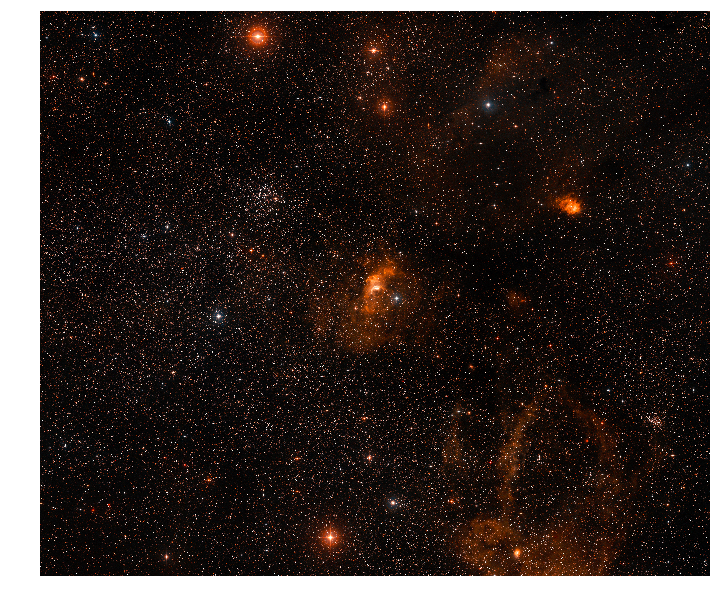

In [17]:
image_plot(newImg.astype(np.uint8))

Y tambien mostramos la matrix en __float32__.

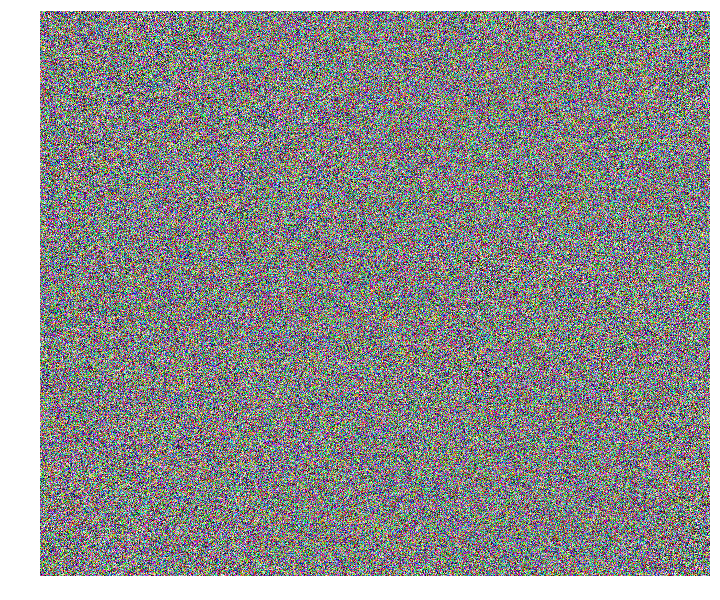

In [18]:
image_plot(newImg)

#3. Ejecute su solución anterior sobre un _pool_ de `1`, `2`, `4` y `8` _engines_ realizando un análisis de tiempo con `%timeit`. Extraiga conclusiones de los resultados obtenidos (considere las características del CPU de su computador). 

Con 1 engine.

In [29]:
rc = Client()
rc.ids

[0]

In [32]:
%px import os, time

In [33]:
%%px --targets 0:1
print(os.getpid())

[stdout:0] 11841


In [36]:
%%timeit
view = rc[:]
print(view)
res = view.map_sync(sample, [0,1,2])

<DirectView [0]>
<DirectView [0]>
<DirectView [0]>
<DirectView [0]>
1 loop, best of 3: 1min per loop


Con 2 engine.

In [42]:
rc = Client()
rc.ids

[0, 1]

In [43]:
%px import os, time

In [44]:
%%px --targets 0:2
print(os.getpid())

[stdout:0] 11890
[stdout:1] 11891


In [46]:
%%timeit
view = rc[:]
print(view)
res = view.map_sync(sample, [0,1,2])

<DirectView [0, 1]>
<DirectView [0, 1]>
<DirectView [0, 1]>
<DirectView [0, 1]>
1 loop, best of 3: 43.4 s per loop


Con 4 engine.

In [49]:
rc = Client()
rc.ids

[0, 1, 2, 3]

In [50]:
%px import os, time

In [51]:
%%px --targets 0:4
print(os.getpid())

[stdout:0] 11984
[stdout:1] 11985
[stdout:2] 11987
[stdout:3] 11986


In [54]:
%%timeit
view = rc[:]
print(view)
res = view.map_sync(sample, [0,1,2])

<DirectView [0, 1, 2, 3]>
<DirectView [0, 1, 2, 3]>
<DirectView [0, 1, 2, 3]>
<DirectView [0, 1, 2, 3]>
1 loop, best of 3: 32.8 s per loop


Con 8 engine.

In [55]:
rc = Client()
rc.ids

[0, 1, 2, 3, 4, 5, 6, 7]

In [57]:
%px import os, time

In [58]:
%%px --targets 0:8
print(os.getpid())

[stdout:0] 12073
[stdout:1] 12072
[stdout:2] 12067
[stdout:3] 12069
[stdout:4] 12068
[stdout:5] 12071
[stdout:6] 12066
[stdout:7] 12070


In [61]:
%%timeit
view = rc[:]
print(view)
res = view.map_sync(sample, [0,1,2])

<DirectView [0, 1, 2, 3,...]>
<DirectView [0, 1, 2, 3,...]>
<DirectView [0, 1, 2, 3,...]>
<DirectView [0, 1, 2, 3,...]>
1 loop, best of 3: 34.9 s per loop


Lo que se concluye, es que a medida que aumenta la cantidad de __engines__ (CPU) el tiempo en que se demora el proceso en total disminuye, dando una mejora de velocidad. Esto producto de que como se necesitan 3 procesos independientes para realizar el proceso global, ya con tener 4 __engines__ ya hace la pega pedida, que seria casi el mismo tiempo que con 8 __engines__ ya que solo requiere 3. 